In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing

In [2]:
Store = 34
w = ['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'] 
data = pd.read_csv('Store'+str(Store)+'\Store'+str(Store)+'_item_filled_20180103-20190711.csv',index_col=0) 
data['BusinessDate'] = pd.to_datetime(data['BusinessDate'])
#Specify Date-Time Variable Types
date_time = ['OrderStartDateTime','NormalDateTime','BumpedDateTime','CookingDateTime','DayHalfHour','DayQuarterHour']
for i in date_time:
    data.loc[:,i] = pd.to_datetime(data.loc[:,i], format="%Y-%m-%d %H:%M:%S.%f")

In [3]:
data.shape

(960934, 63)

In [4]:
data.columns

Index(['StoreKey', 'BusinessDate', 'DateKey', 'DayOfWeek', 'TimeKey',
       'FullHour', 'HalfHour', 'QuarterHour', 'StartTime', 'Holiday',
       'CheckNum', 'GuestCount', 'TableOpenMinutes', 'OpenHour', 'OpenMinute',
       'CloseHour', 'CloseMinute', 'ChannelKey', 'TypeofServiceNum',
       'ProductKey', 'CourseName', 'IXIName', 'MajorCodeName', 'MinorCodeName',
       'StationKey', 'StationName', 'SentTime', 'OrderStartDateTime',
       'NormalDateTime', 'CookingDateTime', 'BumpedDateTime', 'NatHolidayDesc',
       'EmployeeKey', 'TicketTime', 'RNK', 'PROD_RNK', 'ORDER_RNK',
       'TypeofServiceCat', 'ChannelName', 'StartTime.1', 'OffSiteOrder',
       'OnSiteOrder', 'TotalOrder', 'OnSiteItem', 'OffSiteItem', 'TotalItem',
       'HalfHourStart', 'Hour', 'DayHalfHour', 'DayQuarterHour',
       'DayOfWeekName', 'Week', 'Weekday', 'OrderTimeMin',
       'BumpedDateTime_fill', 'OpenDateTime', 'CloseDateTime',
       'OnSiteOrder_fill', 'OffSiteOrder_fill', 'OnSiteItem_fill',
       'O

In [5]:
OperatingHour = pd.read_excel('Operating Hours.xlsx',sheet_name=str(Store))

# Day-Time Clustering

In [6]:
Day_Time1 = pd.read_csv('Store'+str(Store)+'\Store'+str(Store)+'_day-15min.csv',index_col=0)
Day_Time1['BusinessDate'] = pd.to_datetime(Day_Time1['BusinessDate'])
Day_Time1['DayQuarterHour'] = pd.to_datetime(Day_Time1['DayQuarterHour'])
Day_Time1['DayQuarterHourEnd'] = pd.to_datetime(Day_Time1['DayQuarterHourEnd'])

#Identify day of week: 0 represents Mon, 6 represents Sun 
Day_Time1['DayOfWeek'] = Day_Time1['BusinessDate'].dt.weekday
Day_Time1['DayOfWeekName'] = Day_Time1['BusinessDate'].dt.weekday_name
Day_Time1['Week'] = Day_Time1['BusinessDate'].dt.week

#Create Label for whole hour (for graphing)
Day_Time1['Label1'] = Day_Time1['QuarterHour'].apply(lambda x: x.is_integer())
Day_Time1['Label2'] = Day_Time1['QuarterHour'].apply(lambda x: (x/2).is_integer()) 
#Day_Time1['Label1'] = np.where(Day_Time1['QuarterHour']==24,False,Day_Time1['Label1'])
#Day_Time1['Label2'] = np.where(Day_Time1['QuarterHour']==24,False,Day_Time1['Label2'])

#Calculate Total Item and Total Order
Day_Time1['TotalItem']=Day_Time1['OnSiteItem']+Day_Time1['OffSiteItem']
Day_Time1['TotalOrder']=Day_Time1['OnSiteOrder']+Day_Time1['OffSiteOrder']

# Remove Out of Operating Time
d=pd.DataFrame()
for i in w:
    d = d.append(Day_Time1[((Day_Time1['DayOfWeekName']==i)&(Day_Time1['QuarterHour']>=OperatingHour.loc[i,'Open'])&(Day_Time1['QuarterHour']<OperatingHour.loc[i,'Close']))])
Day_Time1 = d
del d

KeyError: 'Monday'

In [7]:
Day_Time1.shape

(28047, 28)

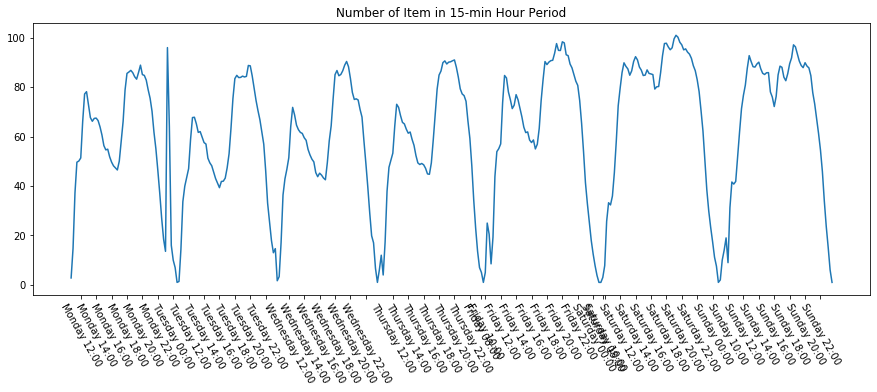

In [8]:
#Weekly Trend of TotalItem
plt_data1 = Day_Time1
plt_data1['Time'] = plt_data1['DayQuarterHour'].dt.weekday_name + ' '+ plt_data1['StartTime']
plt_data1 = plt_data1.groupby('Time')[['DayOfWeek','TotalItem','Label2','QuarterHour']].mean().reset_index().sort_values(by=['DayOfWeek','Time']).reset_index().drop(columns='index')
fig = plt.figure(figsize=(15,5))
plt.plot(plt_data1['Time'],plt_data1['TotalItem'])
plt.xticks(plt_data1['Time'][plt_data1['Label2']],rotation=300)
plt.title('Number of Item in 15-min Hour Period')

del plt_data1

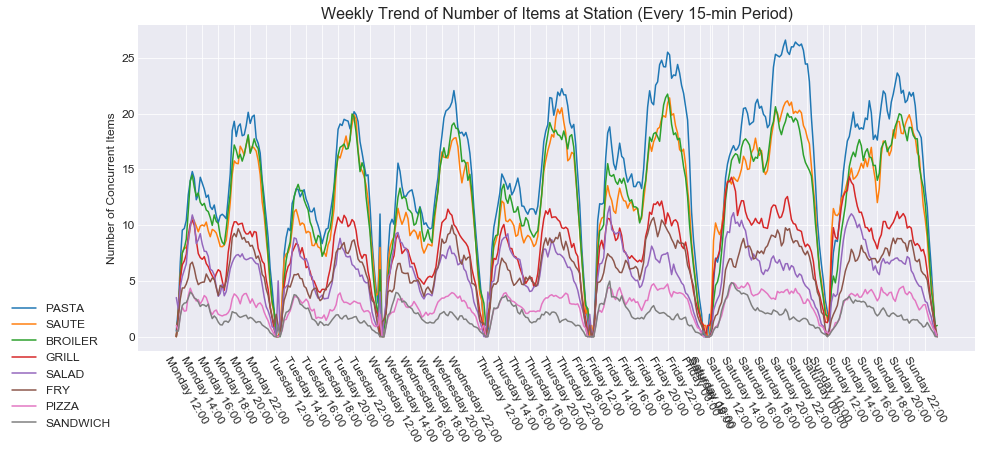

In [9]:
#Weekly Trend of Item at Station
plt.style.use('seaborn-dark')
plt_data2=Day_Time1[(Day_Time1['BusinessDate']>='2018-07-11')&(Day_Time1['Holiday']==0)].drop(columns=['Week','TotalOrder','TotalItem','OnSiteOrder','OnSiteItem','OffSiteOrder','OffSiteItem'])
plt_data2['Time'] = plt_data2['BusinessDate'].dt.weekday_name + ' '+ plt_data2['StartTime']
plt_data2 = plt_data2.groupby('Time').mean().reset_index().sort_values(by=['DayOfWeek','QuarterHour'],ascending=True).reset_index().drop(columns='index')
fig = plt.figure(figsize=(15,6))
s = data['StationName'].value_counts().index
#Create color map with Cheesecake colors
cmap = ['#623b2a','#840b55','#ce0058','#d3bc8d','#b36924','a8ad00']
for i in range(len(s)):
    plt.plot(plt_data2['Time'],plt_data2.loc[:,s[i]],label=s[i])
plt.xticks(plt_data2['Time'][plt_data2['Label2']],rotation=300,fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Number of Concurrent Items',fontsize=12)
plt.legend(bbox_to_anchor=(-0.02,0.18),fontsize=12)
plt.title('Weekly Trend of Number of Items at Station (Every 15-min Period)',fontsize=16)
plt.grid()

del plt_data2

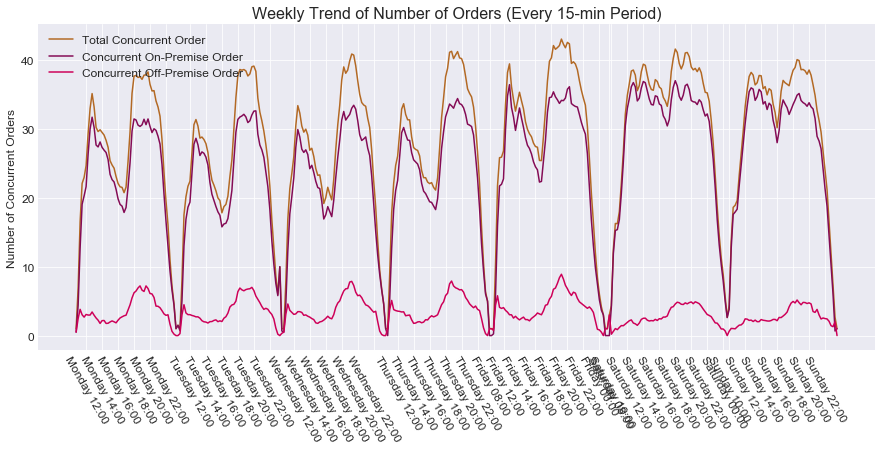

In [10]:
#Weekly Trend of Order by Channel
plt.style.use('seaborn-dark')
plt_data3=Day_Time1[(Day_Time1['BusinessDate']>='2018-07-11')&(Day_Time1['Holiday']==0)][['BusinessDate','StartTime','QuarterHour','DayOfWeek','Time','TotalOrder','OnSiteOrder','OffSiteOrder','Label2']]
plt_data3['Time'] = plt_data3['BusinessDate'].dt.weekday_name + ' '+ plt_data3['StartTime']
plt_data3 = plt_data3.groupby('Time').mean().reset_index().sort_values(by=['DayOfWeek','QuarterHour'],ascending=True).reset_index().drop(columns='index')

fig = plt.figure(figsize=(15,6))
s = ['TotalOrder','OnSiteOrder','OffSiteOrder']
l = ['Total Concurrent Order','Concurrent On-Premise Order','Concurrent Off-Premise Order']
cmap = ['#b36924','#840B55','#CE0058']
for i in range(3):
    plt.plot(plt_data3['Time'],plt_data3.loc[:,s[i]],label=l[i],c=cmap[i])
plt.xticks(plt_data3['Time'][plt_data3['Label2']],rotation=300,fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Number of Concurrent Orders',fontsize=12)
plt.legend(loc=2,fontsize=12)
plt.title('Weekly Trend of Number of Orders (Every 15-min Period)',fontsize=16)
plt.grid()
del plt_data3 

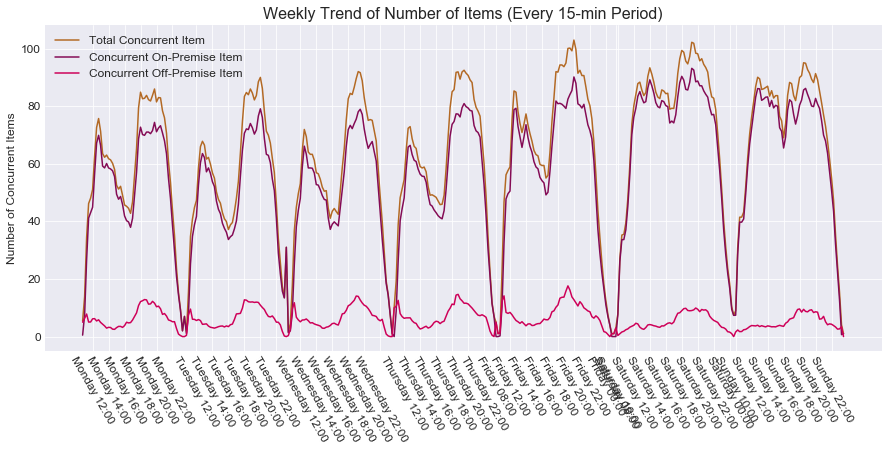

In [11]:
#Weekly Trend of Item by Channel
plt.style.use('seaborn-dark')
plt_data3=Day_Time1[(Day_Time1['BusinessDate']>='2018-07-11')&(Day_Time1['Holiday']==0)][['BusinessDate','StartTime','QuarterHour','DayOfWeek','Time','TotalItem','OnSiteItem','OffSiteItem','Label2']]
plt_data3['Time'] = plt_data3['BusinessDate'].dt.weekday_name + ' '+ plt_data3['StartTime']
plt_data3 = plt_data3.groupby('Time').mean().reset_index().sort_values(by=['DayOfWeek','QuarterHour'],ascending=True).reset_index().drop(columns='index')

plt.figure(figsize=(15,6))
s = ['TotalItem','OnSiteItem','OffSiteItem']
l = ['Total Concurrent Item','Concurrent On-Premise Item','Concurrent Off-Premise Item']
cmap = ['#b36924','#840B55','#CE0058']
for i in range(3):
    plt.plot(plt_data3['Time'],plt_data3.loc[:,s[i]],label=l[i],c=cmap[i])
plt.xticks(plt_data3['Time'][plt_data3['Label2']],rotation=300,fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Number of Concurrent Items',fontsize=12)
plt.legend(loc=2,fontsize=12)
plt.title('Weekly Trend of Number of Items (Every 15-min Period)',fontsize=16)
plt.grid()
del plt_data3 

C:\Users\jrush\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


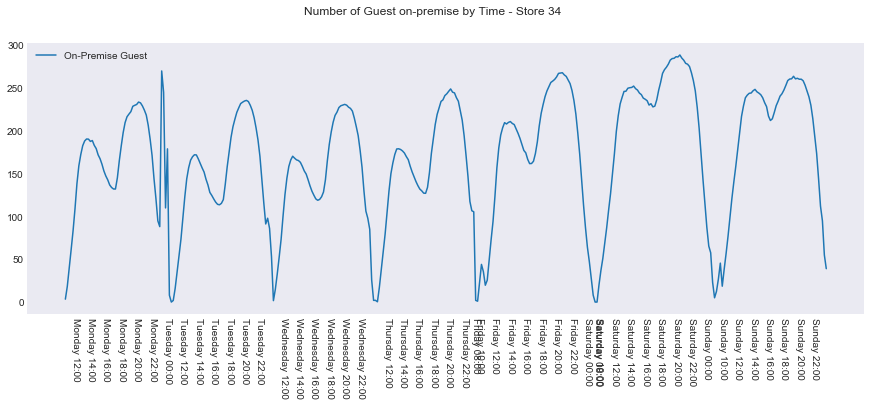

In [12]:
plt_data4=Day_Time1[['BusinessDate','DayQuarterHour','StartTime','QuarterHour','DayOfWeek','Time','OnSiteGuest','Label2']]
#plt_data4['OrderDate'] = np.where(plt_data4['QuarterHour']>=24,plt_data4['BusinessDate']+pd.to_timedelta(1,unit='day'),plt_data4['BusinessDate'])
plt_data4['Time'] = plt_data4['DayQuarterHour'].dt.weekday_name + ' '+ plt_data4['StartTime']
plt_data4 = plt_data4.groupby('Time').mean().reset_index().sort_values(by=['DayOfWeek','QuarterHour'],ascending=True).reset_index().drop(columns='index')

fig = plt.figure(figsize=(15,5))
plt.plot(plt_data4['Time'],plt_data4.loc[:,'OnSiteGuest'],label='On-Premise Guest')
plt.xticks(plt_data4['Time'][plt_data4['Label2']],rotation=270)
plt.legend(loc=2)
fig.suptitle('Number of Guest on-premise by Time - Store ' + str(Store))

del plt_data4

In [13]:
data['OnSiteItem'].max()

109.0

In [14]:
data['OnSiteGuest'].max()

342.0

In [15]:
data['OnSiteOrder'].max()

40.0

### Clustering

In [16]:
#Aggregate number of order and item to DayOfWeek-Time level (15-minute periods in an average week)
class_data1 = Day_Time1[(Day_Time1['Holiday']==0)&(Day_Time1['BusinessDate']>='2018-07-11')].drop(columns=['Week','Holiday','OnSiteOrder','OnSiteItem','OffSiteOrder','OffSiteItem','TimeKey']).groupby(['DayOfWeek','StartTime']).mean().reset_index()
s = data['StationName'].unique()
for i in s: 
    class_data1.loc[:,i] = class_data1.loc[:,i] / class_data1['TotalItem']
class_data1 = class_data1.fillna(0)
#Scaling
class_data1_scaled = preprocessing.scale(class_data1.drop(columns=['StartTime','Label1','Label2','DayOfWeek','QuarterHour']))
class_data1.head() 

,DayOfWeek,StartTime,StoreKey,QuarterHour,BROILER,FRY,GRILL,PASTA,PIZZA,SALAD,SANDWICH,SAUTE,OnSiteGuest,Label1,Label2,TotalItem,TotalOrder
0,0,10:45,34,10.75,0.000000,0.000000,0.000000,0.090909,0.181818,0.636364,0.090909,0.000000,0.500000,False,False,5.500000,1.000000
1,0,11:00,34,11.00,0.145706,0.130368,0.145706,0.185583,0.041411,0.177914,0.035276,0.138037,16.297872,True,False,13.872340,6.808511
2,0,11:15,34,11.25,0.154416,0.098209,0.150710,0.194565,0.057443,0.130327,0.053119,0.161211,36.255319,False,False,34.446809,16.531915
3,0,11:30,34,11.50,0.162598,0.094427,0.139567,0.206817,0.057117,0.116997,0.060341,0.162137,57.425532,False,False,46.191489,22.085106
4,0,11:45,34,11.75,0.164675,0.090748,0.141213,0.201859,0.047366,0.124391,0.062417,0.167331,78.000000,False,False,48.063830,22.957447


In [17]:
#Set Number of Clusters
n1= 6
kmeans = KMeans(n_clusters=n1,random_state=0).fit(class_data1_scaled)
#Retrieve Cluster Result and Store in column 'Class' 
class_data1['Class'] = None
for i in range(n1):
    class_data1['Class'] = np.where(kmeans.labels_==i,i,class_data1['Class'])
class_data1['Class']=class_data1['Class'].astype('object') 

In [18]:
#Calculate Original Cluster Centers
cluster1 = []
for i in range(n1):
    cluster1.append(class_data1[class_data1['Class']==i].mean())
cluster1 = pd.DataFrame(cluster1)
#Sorting Clusters by TotalItem, TotalOrder
cluster_ranking1 = cluster1.sort_values(by=['TotalItem','TotalOrder'],ascending=False).reset_index().drop(columns='index').reset_index()[['Class','index']]
cluster_ranking1.columns=['Class','Rank']
cluster_ranking1 = cluster_ranking1.set_index('Class')
#Rank the Clusters: cluster with fewer item and orders assigned with smaller number for 'RankedClass'
class_data1['RankedClass'] = None
for i in range(n1): 
    class_data1['RankedClass'] = np.where(class_data1['Class']==i,cluster_ranking1.loc[i,'Rank'],class_data1['RankedClass'])

([<matplotlib.axis.YTick at 0x1cc614ca320>,
 <a list of 15 Text yticklabel objects>)

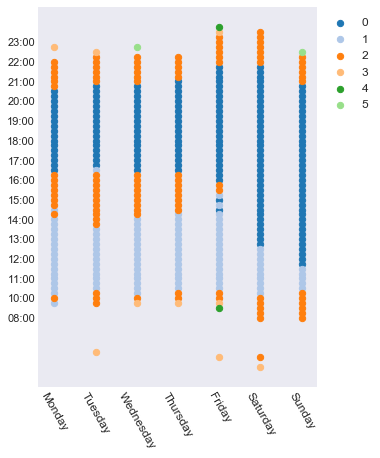

In [19]:
#Visualize Cluster Result
palatte = plt.get_cmap('tab20')
fig = plt.figure(figsize=(5,7))
for i in range(n1): 
    d = class_data1[class_data1['RankedClass']==i]
    plt.scatter(d['DayOfWeek'],d['QuarterHour'],color=palatte(i),label=i,s=40) 
plt.legend(bbox_to_anchor=(1,1),fontsize=12)
plt.xticks(np.arange(7),w,rotation=300,fontsize=12)
plt.yticks(np.arange(10,24.5),class_data1[class_data1['Label1']].sort_values(by='QuarterHour')['StartTime'].unique(),fontsize=11)

In [20]:
#Calculate and Show Cluster Centers after Ranking
cluster_result = []
for i in range(n1):
    cluster_result.append(class_data1.drop(columns=['Class','QuarterHour','Label1','Label2'])[class_data1['RankedClass']==i].mean().append(pd.Series({'Count':class_data1[class_data1['RankedClass']==i]['Class'].count()})))
cluster_result = pd.DataFrame(cluster_result)
cluster_result.drop(columns=['DayOfWeek']).sort_values(by='RankedClass').set_index('RankedClass') 

,StoreKey,BROILER,FRY,GRILL,PASTA,PIZZA,SALAD,SANDWICH,SAUTE,OnSiteGuest,TotalItem,TotalOrder,Count
RankedClass,,,,,,,,,,,,,
0.0,34.0,0.201778,0.095081,0.116634,0.242211,0.042544,0.078799,0.022784,0.200169,229.112664,83.606501,36.356709,171.0
1.0,34.0,0.182977,0.086231,0.130408,0.209225,0.050743,0.126335,0.048060,0.166021,153.490236,62.679128,28.888117,97.0
2.0,34.0,0.189302,0.095534,0.129297,0.234721,0.043629,0.081515,0.023986,0.202016,108.646528,34.655117,16.206150,101.0
3.0,34.0,0.058333,0.337169,0.261111,0.000000,0.000000,0.274735,0.029762,0.038889,11.722222,4.074074,1.277778,9.0
4.0,34.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,9.000000,1.000000,1.000000,2.0
5.0,34.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.500000,1.000000,1.000000,2.0


In [22]:
#Manually Merge the last few clusters with 1 or 2 observations 
#class_data1['RankedClass']=np.where(class_data1['RankedClass']>=22,22,class_data1['RankedClass'])

([<matplotlib.axis.YTick at 0x1cc667202e8>,
 <a list of 15 Text yticklabel objects>)

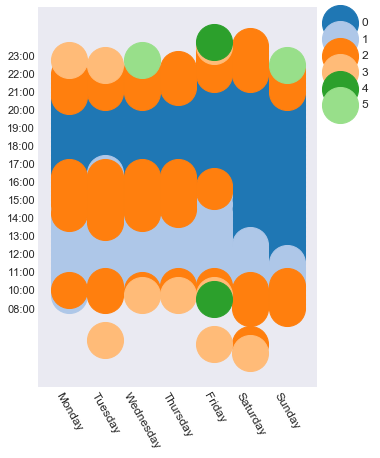

In [21]:
#Visualize Cluster Result
palatte = plt.get_cmap('tab20')
fig = plt.figure(figsize=(5,7))
for i in range(class_data1['RankedClass'].max()+1): 
    d = class_data1[class_data1['RankedClass']==i]
    plt.scatter(d['DayOfWeek'],d['QuarterHour'],color=palatte(i),label=i,s=1300) 
plt.legend(bbox_to_anchor=(1,1),fontsize=12)
plt.xticks(np.arange(7),w,rotation=300,fontsize=12)
plt.yticks(np.arange(10,24.5),class_data1[class_data1['Label1']].sort_values(by='QuarterHour')['StartTime'].unique(),fontsize=11)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

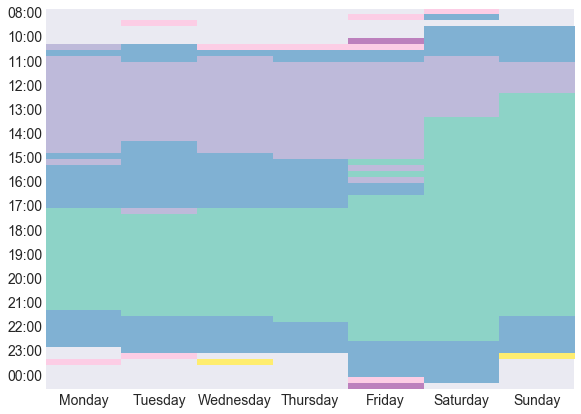

In [22]:
from matplotlib.colors import ListedColormap
newcmp = ListedColormap(['#623B2A','#B36924','#840b55','#D3BC8D'])
class_data1['RankedClass'] = class_data1['RankedClass'].astype('int')
d = pd.pivot_table(class_data1, values='RankedClass', columns=['DayOfWeek'],index=['QuarterHour'],aggfunc=np.mean)
plt.figure(figsize=(12,7))
plt.xticks(np.arange(7),w,fontsize=12)

ytick = list(class_data1[class_data1['Label1']].sort_values(by='QuarterHour')['StartTime'].unique())
m1 = class_data1[class_data1['Label1']]['QuarterHour'].min()
m2 = class_data1[class_data1['Label1']]['QuarterHour'].max()
plt.imshow(d,aspect=0.08,cmap='Set3') #change aspect = 0.08 to align axis 
plt.yticks(np.arange(len(ytick))*4.0,ytick,fontsize=14)
plt.xticks(fontsize=14)

In [23]:
#Save result to Excel file, Excel File MUST be created first
#See Store 160 as an example of automatically  create time cluster graphs using pivot table and conditional formatting
from openpyxl import load_workbook
book = load_workbook('Store'+str(Store)+'\Store'+str(Store)+'_Time Clusters.xlsx')
writer = pd.ExcelWriter('Store'+str(Store)+'\Store'+str(Store)+'_Time Clusters.xlsx', engine='openpyxl') 
writer.book = book
writer.sheets = dict((ws.title, ws) for ws in book.worksheets)
class_data1.to_excel(writer,sheet_name='Raw Data')
cluster_result.to_excel(writer,sheet_name='Cluster Center')
#data_filtered.to_excel(writer, "Main", cols=['Diff1', 'Diff2'])
writer.save() 


### Fill Clustering Result back to Data and Save

In [24]:
#Merge the Clustering Result back to data: Store in column 'Class'
class1_criteria = {}
for i in range(class_data1['RankedClass'].max()+1):
    class1_criteria[i] = class_data1[class_data1['RankedClass']==i][['DayOfWeek','QuarterHour']]

data['Class']=None    
for i in range(class_data1['RankedClass'].max()+1):
    for j in list(class1_criteria[i].index): 
        data['Class'] = np.where((data['DayOfWeek']==class1_criteria[i].loc[j,'DayOfWeek'])&
                             (data['QuarterHour']==class1_criteria[i].loc[j,'QuarterHour']),i,data['Class'])

In [ ]:
data.to_csv('Store'+str(Store)+'\Store'+str(Store)+'_variable+15min-cluster.csv') 

In [ ]:
data.groupby('Class')['ProductKey'].count()

# Day-Time Cluster: Bottleneck Station

## Clustering